# Generating Product Reviews using AI

The main purpose of this project is to demonstrate AI tooling on existing, multilingual product reviews. This part is in the `review_extraction.ipynb` notebook.

However, before I do this, I need a dataset. I'm going to generate synthetic reviews using an AI model. I'll add weightings and specifications so the reviews are suitably varied.

First, I'll install and import needed libraries.

In [1]:
# Install packages if needed
# !pip install langchain
# !pip install cohere
# !pip install tiktoken
# !pip install openai
# !pip install python-dotenv

In [20]:
# Import libraries
from dotenv import load_dotenv
import os
import json
import pandas as pd
import random
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain.schema.output_parser import OutputParserException 
from langchain.prompts import PromptTemplate
from langchain.pydantic_v1 import BaseModel, Field, validator
from pydantic import ValidationError

# Load environment variables from .env
load_dotenv()

# Allow DataFrame width to match content
pd.set_option('display.max_colwidth', None)

ModuleNotFoundError: No module named 'langchain_core'

## Generating Product Titles

Before we can generate reviews, we need some products to review. I could do this by hand, but let's get AI to do the job.


I'm going to use LangSmith to track model calls. This is probably over the top for this project and it allows easy tracking of model calls. I've already set this up in the `.env` file, which is already loaded.

First, we'll make a simple test call.

In [3]:
llm = ChatOpenAI()
llm.invoke("Hello, world!")

AIMessage(content='Hello there! How can I assist you today?')

Below you can see the two LLM calls have been logged on LangSmith. It's collected useful information such as latency and token count.

Now I know that's working, it's time to move on.

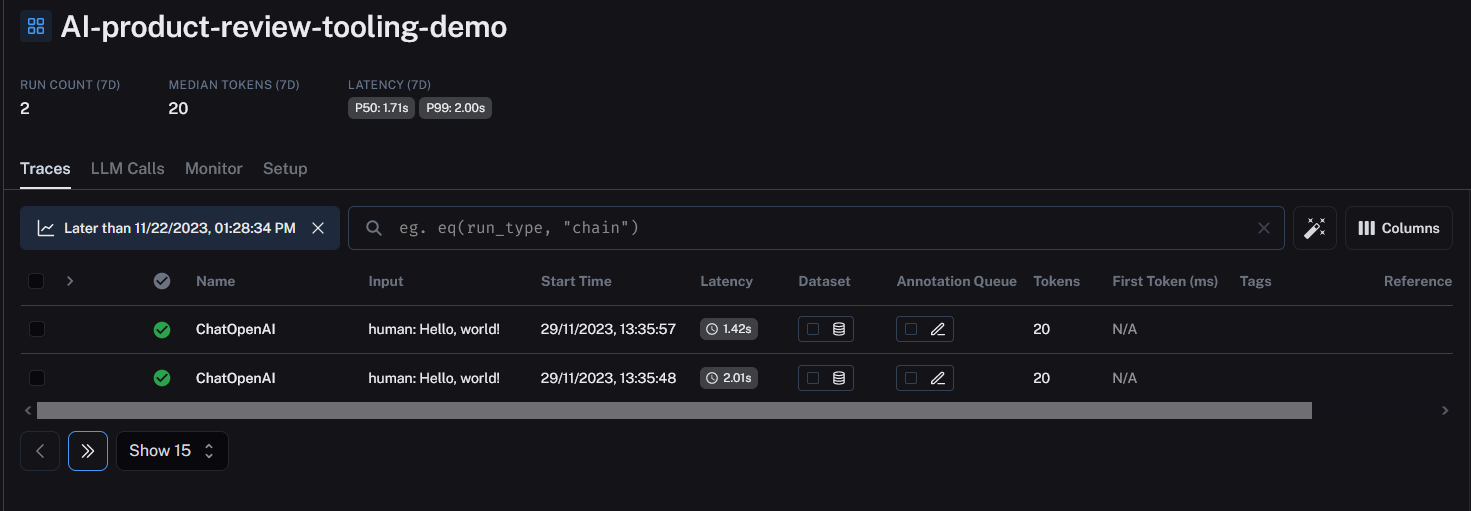

In [15]:
# Initialise the model
model_name = "gpt-3.5-turbo-instruct"
temperature = 0.7
model = OpenAI(model_name=model_name, temperature=temperature)

# Defining desired data structure
class Product(BaseModel):
    name: str = Field(description="name of the product")
    description: str = Field(description="description of the product")

# Set up a parser + inject instructions into the prompt template.
parser = PydanticOutputParser(pydantic_object=Product)

prompt = PromptTemplate(
    template="""Invent a creative name for a new outdoors product. The name \
    must also explain what the product does. \
    The product must in a different category to the following products: \
    \
    ```\n{prev_prods}\n``` \
    \
    Make sure the product is in a different sector(clothing, watersports, \
    rock climbing, hiking, mountain biking, snowboarding, etc.) to any of \
    the above examples.\
    \
    \n{format_instructions}\n \
    """,
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

Now I have 10 products to be reviewed. I could easily generate reviews based solely on these descriptions, but to make it more interesting, and realistic, I'm going to add some weighting. I want some products to be consistently good, and others to be consistently poor.

## Weighting Products

Again, I could manually weight each product. But that doesn't scale. Instead, I'll assign each product an overall score, and use that to bias randomised weightings.

The metrics I'm going to use are `aesthetics`, `quality`, `ease of use`, `cost`, and `value`.

To ensure a good spread of ratings, I'm going to assign two products to each overall score(1-5).

In [ ]:
# Assign each row a score 'overall rating' from 1-5 based on index
products['overall_rating'] = (products.index // 2) + 1

products

,name,description,overall_rating
0,TrailTote,"A versatile and durable backpack specifically designed for hiking and camping, featuring multiple pockets and compartments for easy organization of gear and supplies on the go.",1
1,TrailPak,"A compact and versatile outdoor backpack designed for hikers, campers, and adventurers. Features include multiple compartments for organization, weather-resistant materials, and adjustable straps for a comfortable fit.",1
2,Trailblaze Tent Hammock,"A versatile camping solution that combines the comfort of a hammock with the shelter of a tent, perfect for adventurous hikers looking to minimize their gear.",2
3,TrailTrek Tentmate,A compact and versatile tent attachment for easy storage and organization of outdoor gear on the go.,2
4,TrailBuddy,"A portable, all-in-one hiking and camping tool that includes a compass, flashlight, and multi-tool for convenient and compact outdoor exploration.",3
5,WanderShield,"A portable, lightweight shelter for camping and outdoor activities, providing protection from wind and rain while still allowing for a panoramic view of the surroundings.",3
6,TrailTote,"A lightweight and durable backpack specifically designed for hikers and campers. Features include multiple pockets for organization, built-in rain cover, and a hydration pouch for easy access to water on the go.",4
7,TrailTote,"A versatile, lightweight backpack designed to securely carry all your hiking essentials, from water bottles and snacks to maps and first aid supplies, for a comfortable and convenient outdoor experience.",4
8,TrailTote,"A versatile and durable backpack designed for outdoor adventures. Perfect for storing all your essentials while hiking, camping, or exploring the great outdoors.",5
9,NatureShield,"A durable, all-weather tent designed to protect you from the elements and provide a comfortable outdoor experience.",5


Now all the products are rated, I'm going to create a separate df for each product, and populate it with 20 weighted and randomised reviews.

In [ ]:
def weight_products(product):
    ''' 
    Generate random integers based on weighting for `aesthetics`, `quality`,
    `ease of use`, `cost`, and `value`.
    '''

     # Create a copy of the product object
    product = product.copy()
    
    # Set the rating range
    if product['overall_rating'] == 1:
        min, max = 1, 2
    elif product['overall_rating'] == 5:
        min, max = 4, 5
    else:
        min, max = product['overall_rating'] - 1, product['overall_rating'] + 1
    
    # Generate the final scores
    product['aesthetics'] = random.randint(min, max)
    product['quality'] = random.randint(min, max)
    product['ease of use'] = random.randint(min, max)
    product['cost'] = random.randint(min, max)
    product['value'] = random.randint(min, max)
    return product

product_list = []
# Generates a new df called product{index} for each product each with 20 rows
for index, product in products.iterrows():
    df = pd.DataFrame([weight_products(product) for _ in range(20)])
    df.reset_index(drop=True, inplace=True)
    name = f'product{index}'
    product_list.append(name)
    globals()[name] = df

product7.head()

,name,description,overall_rating,aesthetics,quality,ease of use,cost,value
0,TrailTote,"A versatile, lightweight backpack designed to securely carry all your hiking essentials, from water bottles and snacks to maps and first aid supplies, for a comfortable and convenient outdoor experience.",4,3,3,4,5,3
1,TrailTote,"A versatile, lightweight backpack designed to securely carry all your hiking essentials, from water bottles and snacks to maps and first aid supplies, for a comfortable and convenient outdoor experience.",4,4,4,5,4,3
2,TrailTote,"A versatile, lightweight backpack designed to securely carry all your hiking essentials, from water bottles and snacks to maps and first aid supplies, for a comfortable and convenient outdoor experience.",4,5,4,5,5,5
3,TrailTote,"A versatile, lightweight backpack designed to securely carry all your hiking essentials, from water bottles and snacks to maps and first aid supplies, for a comfortable and convenient outdoor experience.",4,4,3,3,3,5
4,TrailTote,"A versatile, lightweight backpack designed to securely carry all your hiking essentials, from water bottles and snacks to maps and first aid supplies, for a comfortable and convenient outdoor experience.",4,3,4,3,5,5


Now we have 20 synthetic reviewers, each with slightly different weightings. The next step is to generate the actual reviews.

## Generating Reviews

I'm not going to pass over `overall_rating` and instead will base the reviews of the randomised weightings.

To make the reviews multilingual, I'll randomly set the language between English, French, and Spanish. I'm also going to randomise the length of the review to increase variability.

In [ ]:
# Initialise the model
model_name = "gpt-3.5-turbo-instruct"
temperature = 0.8
review_model = OpenAI(model_name=model_name, temperature=temperature)

def get_review(product):
    # Create a copy of the product object
    product = product.copy()

    # Choose a language
    languages = ['English', 'French', 'Spanish']
    lang = random.choice(languages)

    # Set length
    length = random.randint(2, 7)

    # Generate the review
    prompt = f'''You are a discerning product reviewer. You are reviewing \
    {product['name']}. It's description states: \
    {product['description']} \
    Your rating of the products are between 1(lowest) and 5(highest). \
    Aesthetics: {product['aesthetics']} \
    Quality: {product['quality']} \
    Ease of use: {product['ease of use']} \
    Cost: {product['cost']} \
    Value: {product['value']} \
    Please write a review in {lang} with {length} sentences. \
    Do not explicitly mention your scores. \
    '''
    output = review_model.invoke(prompt)

    # Add the review to the dataframe
    product['review'] = output.strip()
    return product



Let's check that on two products.

In [ ]:
product1.head(2).apply(get_review, axis=1)

,name,description,overall_rating,aesthetics,quality,ease of use,cost,value,review
0,TrailPak,"A compact and versatile outdoor backpack designed for hikers, campers, and adventurers. Features include multiple compartments for organization, weather-resistant materials, and adjustable straps for a comfortable fit.",1,2,2,2,2,2,"Me parece que TrailPak es una mochila compacta y versátil ideal para excursionistas, campistas y aventureros. Tiene múltiples compartimentos para organización, materiales resistentes a la intemperie y correas ajustables para un ajuste cómodo. Sin embargo, en términos de estética, calidad, facilidad de uso y costo, no se destacó particularmente en comparación con otras mochilas similares en el mercado. En general, considero que la relación calidad-precio de TrailPak es promedio."
1,TrailPak,"A compact and versatile outdoor backpack designed for hikers, campers, and adventurers. Features include multiple compartments for organization, weather-resistant materials, and adjustable straps for a comfortable fit.",1,1,1,2,1,2,"TrailPak parece ser un mochila compacta y versátil para actividades al aire libre, como senderismo, camping y aventuras. Cuenta con múltiples compartimentos para mantener todo organizado, y está hecho con materiales resistentes al clima. Sin embargo, en términos de estética y calidad, no está a la altura de mis expectativas. Además, no fue fácil de usar y el costo no justifica el valor del producto. En general, no estoy satisfecho con mi experiencia con TrailPak."


In [ ]:
product7.head(2).apply(get_review, axis=1)

,name,description,overall_rating,aesthetics,quality,ease of use,cost,value,review
0,TrailTote,"A versatile, lightweight backpack designed to securely carry all your hiking essentials, from water bottles and snacks to maps and first aid supplies, for a comfortable and convenient outdoor experience.",4,3,3,4,5,3,"TrailTote es una mochila versátil y ligera diseñada para llevar de forma segura todos tus elementos esenciales de senderismo, desde botellas de agua y bocadillos hasta mapas y suministros de primeros auxilios, para una experiencia cómoda y conveniente al aire libre. Si bien el diseño es funcional y práctico, la estética no es particularmente llamativa. Sin embargo, la calidad y el valor por el precio son excelentes, lo que lo convierte en una excelente opción para aquellos que buscan una mochila de senderismo asequible y de buena calidad."
1,TrailTote,"A versatile, lightweight backpack designed to securely carry all your hiking essentials, from water bottles and snacks to maps and first aid supplies, for a comfortable and convenient outdoor experience.",4,4,4,5,4,3,"After thorough testing, I must say that I am impressed with the TrailTote backpack. Its sleek design and high-quality materials make it both visually appealing and durable. The ease of use and convenient compartments make it a must-have for any hiking adventure. Although the cost may be slightly higher than other backpacks, the overall value and functionality make it worth the investment."


Both products' reviews match their ratings. Now all that's left is to generate reviews for every product.

In [ ]:
# Get the current working directory
current_directory = os.getcwd()

# Create the directory if it doesn't exist
directory = os.path.join(current_directory, 'reviews')
os.makedirs(directory, exist_ok=True)

# Generates reviews and writes them to csv
for prod in product_list[]:
    df = globals()[prod]
    print(f'Generating Reviews for {prod}')
    df = df.apply(get_review, axis=1)
    print(f'Writing {prod}.csv')
    df.to_csv(f'reviews/{prod}.csv', index=False)

Generating Reviews for product0
Writing product0.csv
Generating Reviews for product1
Writing product1.csv


## Summary Statistics

Since the project is demonstrating how well AI tooling understands product reviews, it'll be useful to have some summary statistics.

I'm going to keep it simple and work with averages scores.

In [ ]:
# Assuming you have a list of DataFrames called 'df_list'
product_stats = pd.concat(df_list).drop(columns=['description', 'review'])
product_stats = product_stats.groupby('name').mean()
product_stats.sort_values(by='overall_rating', inplace=True)
product_stats.to_csv('reviews/product_stats.csv')

product_stats

,overall_rating,aesthetics,quality,ease of use,cost,value
name,,,,,,
Glampin' Gear,1.0,1.40,1.25,1.25,1.50,1.50
IceEase,1.0,1.35,1.45,1.40,1.70,1.35
CampComfy,2.0,2.15,1.70,2.10,1.85,1.75
NaturGlow,2.0,2.10,1.90,2.00,2.10,1.65
HydroHiker,3.0,3.05,2.75,3.10,3.20,3.20
Treetop Trekker,3.0,3.05,3.25,2.95,2.85,2.90
Camp-Chillers,4.0,3.85,3.90,3.95,4.10,4.25
PathRover,4.0,4.00,3.60,4.00,4.20,3.80
ShadeWeaver,5.0,4.45,4.45,4.45,4.55,4.60


Above, you can see how even though there are two products for each overall rating, their detailed scores still have some variance.

That's the reviews and summary statistics all generated. Now the exciting part is to use AI to extract data from the reviews. That will be done in `review_extraction.ipynb`.

## LangSmith Data

At the start, I mentioned I was tracking this project via [LangSmith](https://smith.langchain.com/). Although it's a bit overboard, it's easy to setup.

It has also let me track token useage. So far, this project has used 
# tokens
with a rough cost of 
# dollars

# insert photo of langsmith dashboard